# AI Project

In [28]:
import tensorflow as tf
from PIL import Image
from skimage import data, io, filters
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold, datasets
import os
import random
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import TensorBoard
import re
from tensorflow.keras.models import load_model
from keras.models import model_from_json
import h5py

**Used google collab to read images and resized them to 128x128x3**

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

In [ ]:
IMG_WIDTH=128
IMG_HEIGHT=128
IMG_CHANNELS=3


TRAIN_IMAGE=r'My Drive/AI Assignment/kaggle images 1/'
TRAIN_MASK=r'My Drive/AI Assignment/kaggle results 1/'

X_IMAGE_ids=next(os.walk(TRAIN_IMAGE))[2]
Y_MASK_ids=next(os.walk(TRAIN_MASK))[2]
X_Train=np.zeros((len(X_IMAGE_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_Train=np.zeros((len(Y_MASK_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)

In [ ]:
for i,j in enumerate(X_IMAGE_ids):
    print(i)
    img=imread(TRAIN_IMAGE+j)[:,:,:IMG_CHANNELS]
    img=resize(img,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range=True)
    X_Train[i]=img

    img=imread(TRAIN_MASK+re.split('.jpg',j)[0]+'.png')


    for l in range(0,len(img)):
    for m in range(0,len(img[0])):
        for n in range(0,4):
            if img[l][m][n]>=1:
                img[l][m][n]=255
            else:
                img[l][m][n]=0
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    img=resize(img,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range=True)

    img=np.expand_dims(img,axis=-1)

    Y_Train[i]=img.astype(np.bool)   

**Loading saved images array after resizing**

In [31]:
IMG_WIDTH=128
IMG_HEIGHT=128
IMG_CHANNELS=3
X_Train=np.load('data/X_TRAIN_4500.npy')
Y_Train=np.load('data/Y_TRAIN_4500.npy')

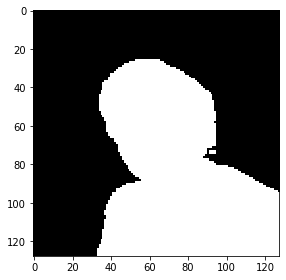

In [32]:
imshow(np.squeeze(Y_Train[4499]))

**Dividing train and test data**

In [14]:
X_TRAIN_NEW=X_Train[0:4499, : , : ,:]
Y_TRAIN_NEW=Y_Train[0:4499, : , : ,:]
X_TRAIN = X_TRAIN_NEW[0:4000, : , : ,:]
Y_TRAIN = Y_TRAIN_NEW[0:4000, : , : ,:]
X_TEST = X_TRAIN_NEW[4000:4499, : , : ,:]
Y_TEST = Y_TRAIN_NEW[4000:4499, : , : ,:]
print(len(X_TRAIN_NEW))
print(len(Y_TRAIN_NEW))
print(len(X_TRAIN))
print(len(Y_TRAIN))
print(len(X_TEST))
print(len(Y_TEST))

4499
4499
4000
4000
499
499


**UNET Model implementation**

In [9]:
def Unet(X_Train,Y_Train):
    inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
    #KERAS TAKE FLOATING VALUES SO WE ARE DIVIDING It BY 255
    s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)
    
    #DOWNSAMPLING 1/2 height and width of image
    
    # STEP 1
    CONVULTIONAL1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
    CONVULTIONAL1=tf.keras.layers.Dropout(0.1)(CONVULTIONAL1)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL1)
    #MAX POOLING
    POOLING1=tf.keras.layers.MaxPool2D((2,2))(CONVULTIONAL1)
    
    #STEP 2
    CONVULTIONAL2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(POOLING1)
    CONVULTIONAL2=tf.keras.layers.Dropout(0.1)(CONVULTIONAL2)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL2)
    #MAX POOLING
    POOLING2=tf.keras.layers.MaxPool2D((2,2))(CONVULTIONAL2)
    
    
    #STEP 4
    CONVULTIONAL3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(POOLING2)
    CONVULTIONAL3=tf.keras.layers.Dropout(0.2)(CONVULTIONAL3)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL3)
    #MAX POOLING
    POOLING3=tf.keras.layers.MaxPool2D((2,2))(CONVULTIONAL3)
    
    
    #STEP 5
    CONVULTIONAL4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(POOLING3)
    CONVULTIONAL4=tf.keras.layers.Dropout(0.2)(CONVULTIONAL4)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL4)
    #MAX POOLING
    POOLING4=tf.keras.layers.MaxPool2D((2,2))(CONVULTIONAL4)
    
     #STEP 6
    CONVULTIONAL5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(POOLING4)
    CONVULTIONAL5=tf.keras.layers.Dropout(0.3)(CONVULTIONAL5)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL5)
    
    
    #EXPANSION PATH
    
    #STEP 1
    UPSAMPLING6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(CONVULTIONAL5)
    UPSAMPLING6=tf.keras.layers.concatenate([UPSAMPLING6,CONVULTIONAL4])
    CONVULTIONAL6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(UPSAMPLING6)
    CONVULTIONAL6=tf.keras.layers.Dropout(0.2)(CONVULTIONAL6)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL6)
    
    
    #STEP 2
    UPSAMPLING7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(CONVULTIONAL6)
    UPSAMPLING7=tf.keras.layers.concatenate([UPSAMPLING7,CONVULTIONAL3])
    CONVULTIONAL7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(UPSAMPLING7)
    CONVULTIONAL7=tf.keras.layers.Dropout(0.2)(CONVULTIONAL7)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL7)
    
    #STEP 3
    UPSAMPLING8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(CONVULTIONAL7)
    UPSAMPLING8=tf.keras.layers.concatenate([UPSAMPLING8,CONVULTIONAL2])
    CONVULTIONAL8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(UPSAMPLING8)
    CONVULTIONAL8=tf.keras.layers.Dropout(0.1)(CONVULTIONAL8)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL8)
    
    #STEP 4
    UPSAMPLING9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(CONVULTIONAL8)
    UPSAMPLING9=tf.keras.layers.concatenate([UPSAMPLING9,CONVULTIONAL1],axis=3)
    CONVULTIONAL9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(UPSAMPLING9)
    CONVULTIONAL9=tf.keras.layers.Dropout(0.1)(CONVULTIONAL9)
    #SINCE FIRST STEP OF MODEL REQUIRE 2 CONVULTIONAL SO I AM AGAIN APPLYING CONVULTIONAL NETWORK
    CONVULTIONAL9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(CONVULTIONAL9)
    
    outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(CONVULTIONAL9)
    
    
    model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_human.h5',verbose=1,save_weights_only=True)
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir='logs')]
    results=model.fit(X_Train,Y_Train,validation_split=0.1,batch_size=1,epochs=250)
    return model,results

**We Trained our model on google collab on 250 epoch and saved it as model.h5**

In [10]:
model,results=Unet(X_TRAIN,Y_TRAIN)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3600 samples, validate on 400 samples
Epoch 1/80


 204/3600 [>.............................] - ETA: 1:49:21 - loss: 0.8334 - acc: 0.53 - ETA: 58:29 - loss: 0.7758 - acc: 0.5314 - ETA: 40:57 - loss: 0.7450 - acc: 0.53 - ETA: 32:09 - loss: 0.7753 - acc: 0.51 - ETA: 26:51 - loss: 0.7537 - acc: 0.53 - ETA: 23:20 - loss: 0.7496 - acc: 0.53 - ETA: 20:46 - loss: 0.7369 - acc: 0.53 - ETA: 18:58 - loss: 0.7363 - acc: 0.51 - ETA: 17:28 - loss: 0.7290 - acc: 0.51 - ETA: 16:17 - loss: 0.7201 - acc: 0.51 - ETA: 15:20 - loss: 0.7217 - acc: 0.51 - ETA: 14:31 - loss: 0.7143 - acc: 0.52 - ETA: 13:48 - loss: 0.7108 - acc: 0.52 - ETA: 13:11 - loss: 0.7148 - acc: 0.51 - ETA: 12:40 - loss: 0.7093 - acc: 0.52 - ETA: 12:12 - loss: 0.7036 - acc: 0.53 - ETA: 11:47 - loss: 0.7050 - acc: 0.53 - ETA: 11:25 - loss: 0.7060 - acc: 0.53 - ETA: 11:05 - loss: 0.7031 - acc: 0.54 - ETA: 10:49 - loss: 0.7038 - acc: 0.53 - ETA: 10:33 - loss: 0.7045 - acc: 0.53 - ETA: 10:18 - loss: 0.7042 - acc: 0.53 - ETA: 10:05 - loss: 0.7040 - acc: 0.54 - ETA: 9:53 - loss: 0.7035 - acc:

1224/3600 [=========>....................] - ETA: 4:06 - loss: 0.4607 - acc: 0.772 - ETA: 4:06 - loss: 0.4604 - acc: 0.772 - ETA: 4:06 - loss: 0.4603 - acc: 0.772 - ETA: 4:06 - loss: 0.4603 - acc: 0.772 - ETA: 4:06 - loss: 0.4601 - acc: 0.772 - ETA: 4:06 - loss: 0.4599 - acc: 0.772 - ETA: 4:05 - loss: 0.4597 - acc: 0.773 - ETA: 4:05 - loss: 0.4597 - acc: 0.773 - ETA: 4:05 - loss: 0.4595 - acc: 0.773 - ETA: 4:05 - loss: 0.4593 - acc: 0.773 - ETA: 4:05 - loss: 0.4591 - acc: 0.773 - ETA: 4:05 - loss: 0.4590 - acc: 0.773 - ETA: 4:05 - loss: 0.4588 - acc: 0.773 - ETA: 4:05 - loss: 0.4587 - acc: 0.774 - ETA: 4:05 - loss: 0.4585 - acc: 0.774 - ETA: 4:05 - loss: 0.4582 - acc: 0.774 - ETA: 4:05 - loss: 0.4579 - acc: 0.774 - ETA: 4:05 - loss: 0.4577 - acc: 0.774 - ETA: 4:04 - loss: 0.4575 - acc: 0.774 - ETA: 4:04 - loss: 0.4573 - acc: 0.774 - ETA: 4:04 - loss: 0.4571 - acc: 0.775 - ETA: 4:04 - loss: 0.4568 - acc: 0.775 - ETA: 4:04 - loss: 0.4566 - acc: 0.775 - ETA: 4:04 - loss: 0.4565 - acc: 0.7

1428/3600 [==========>...................] - ETA: 3:49 - loss: 0.4284 - acc: 0.792 - ETA: 3:49 - loss: 0.4282 - acc: 0.792 - ETA: 3:48 - loss: 0.4279 - acc: 0.792 - ETA: 3:48 - loss: 0.4277 - acc: 0.792 - ETA: 3:48 - loss: 0.4276 - acc: 0.792 - ETA: 3:48 - loss: 0.4274 - acc: 0.793 - ETA: 3:48 - loss: 0.4272 - acc: 0.793 - ETA: 3:48 - loss: 0.4270 - acc: 0.793 - ETA: 3:48 - loss: 0.4269 - acc: 0.793 - ETA: 3:48 - loss: 0.4267 - acc: 0.793 - ETA: 3:48 - loss: 0.4269 - acc: 0.793 - ETA: 3:48 - loss: 0.4266 - acc: 0.793 - ETA: 3:47 - loss: 0.4265 - acc: 0.793 - ETA: 3:47 - loss: 0.4263 - acc: 0.793 - ETA: 3:47 - loss: 0.4265 - acc: 0.793 - ETA: 3:47 - loss: 0.4262 - acc: 0.793 - ETA: 3:47 - loss: 0.4261 - acc: 0.793 - ETA: 3:47 - loss: 0.4258 - acc: 0.794 - ETA: 3:47 - loss: 0.4257 - acc: 0.794 - ETA: 3:47 - loss: 0.4256 - acc: 0.794 - ETA: 3:47 - loss: 0.4254 - acc: 0.794 - ETA: 3:47 - loss: 0.4252 - acc: 0.794 - ETA: 3:47 - loss: 0.4251 - acc: 0.794 - ETA: 3:47 - loss: 0.4248 - acc: 0.7

1632/3600 [============>.................] - ETA: 3:31 - loss: 0.4063 - acc: 0.806 - ETA: 3:31 - loss: 0.4062 - acc: 0.806 - ETA: 3:31 - loss: 0.4061 - acc: 0.807 - ETA: 3:31 - loss: 0.4059 - acc: 0.807 - ETA: 3:30 - loss: 0.4058 - acc: 0.807 - ETA: 3:30 - loss: 0.4057 - acc: 0.807 - ETA: 3:30 - loss: 0.4058 - acc: 0.807 - ETA: 3:30 - loss: 0.4056 - acc: 0.807 - ETA: 3:30 - loss: 0.4054 - acc: 0.807 - ETA: 3:30 - loss: 0.4052 - acc: 0.807 - ETA: 3:30 - loss: 0.4050 - acc: 0.807 - ETA: 3:30 - loss: 0.4050 - acc: 0.807 - ETA: 3:30 - loss: 0.4048 - acc: 0.807 - ETA: 3:30 - loss: 0.4048 - acc: 0.807 - ETA: 3:29 - loss: 0.4046 - acc: 0.807 - ETA: 3:29 - loss: 0.4046 - acc: 0.807 - ETA: 3:29 - loss: 0.4045 - acc: 0.807 - ETA: 3:29 - loss: 0.4043 - acc: 0.807 - ETA: 3:29 - loss: 0.4042 - acc: 0.808 - ETA: 3:29 - loss: 0.4040 - acc: 0.808 - ETA: 3:29 - loss: 0.4038 - acc: 0.808 - ETA: 3:29 - loss: 0.4037 - acc: 0.808 - ETA: 3:29 - loss: 0.4035 - acc: 0.808 - ETA: 3:29 - loss: 0.4033 - acc: 0.8

1836/3600 [==============>...............] - ETA: 3:14 - loss: 0.3886 - acc: 0.817 - ETA: 3:14 - loss: 0.3885 - acc: 0.817 - ETA: 3:14 - loss: 0.3884 - acc: 0.817 - ETA: 3:14 - loss: 0.3882 - acc: 0.817 - ETA: 3:14 - loss: 0.3882 - acc: 0.817 - ETA: 3:14 - loss: 0.3880 - acc: 0.817 - ETA: 3:14 - loss: 0.3879 - acc: 0.817 - ETA: 3:13 - loss: 0.3877 - acc: 0.817 - ETA: 3:13 - loss: 0.3875 - acc: 0.818 - ETA: 3:13 - loss: 0.3874 - acc: 0.818 - ETA: 3:13 - loss: 0.3877 - acc: 0.818 - ETA: 3:13 - loss: 0.3876 - acc: 0.818 - ETA: 3:13 - loss: 0.3877 - acc: 0.818 - ETA: 3:13 - loss: 0.3875 - acc: 0.818 - ETA: 3:13 - loss: 0.3874 - acc: 0.818 - ETA: 3:13 - loss: 0.3873 - acc: 0.818 - ETA: 3:13 - loss: 0.3872 - acc: 0.818 - ETA: 3:13 - loss: 0.3870 - acc: 0.818 - ETA: 3:12 - loss: 0.3870 - acc: 0.818 - ETA: 3:12 - loss: 0.3868 - acc: 0.818 - ETA: 3:12 - loss: 0.3866 - acc: 0.818 - ETA: 3:12 - loss: 0.3865 - acc: 0.818 - ETA: 3:12 - loss: 0.3864 - acc: 0.818 - ETA: 3:12 - loss: 0.3862 - acc: 0.8

2040/3600 [================>.............] - ETA: 2:56 - loss: 0.3727 - acc: 0.826 - ETA: 2:56 - loss: 0.3726 - acc: 0.826 - ETA: 2:56 - loss: 0.3725 - acc: 0.826 - ETA: 2:55 - loss: 0.3724 - acc: 0.826 - ETA: 2:55 - loss: 0.3723 - acc: 0.826 - ETA: 2:55 - loss: 0.3723 - acc: 0.827 - ETA: 2:55 - loss: 0.3721 - acc: 0.827 - ETA: 2:55 - loss: 0.3720 - acc: 0.827 - ETA: 2:55 - loss: 0.3723 - acc: 0.827 - ETA: 2:55 - loss: 0.3722 - acc: 0.827 - ETA: 2:55 - loss: 0.3721 - acc: 0.827 - ETA: 2:55 - loss: 0.3719 - acc: 0.827 - ETA: 2:55 - loss: 0.3721 - acc: 0.827 - ETA: 2:55 - loss: 0.3722 - acc: 0.827 - ETA: 2:54 - loss: 0.3720 - acc: 0.827 - ETA: 2:54 - loss: 0.3719 - acc: 0.827 - ETA: 2:54 - loss: 0.3719 - acc: 0.827 - ETA: 2:54 - loss: 0.3718 - acc: 0.827 - ETA: 2:54 - loss: 0.3718 - acc: 0.827 - ETA: 2:54 - loss: 0.3719 - acc: 0.827 - ETA: 2:54 - loss: 0.3718 - acc: 0.827 - ETA: 2:54 - loss: 0.3717 - acc: 0.827 - ETA: 2:54 - loss: 0.3716 - acc: 0.827 - ETA: 2:54 - loss: 0.3716 - acc: 0.8

2244/3600 [=================>............] - ETA: 2:36 - loss: 0.3602 - acc: 0.834 - ETA: 2:36 - loss: 0.3601 - acc: 0.834 - ETA: 2:36 - loss: 0.3600 - acc: 0.834 - ETA: 2:36 - loss: 0.3599 - acc: 0.834 - ETA: 2:35 - loss: 0.3599 - acc: 0.834 - ETA: 2:35 - loss: 0.3598 - acc: 0.834 - ETA: 2:35 - loss: 0.3597 - acc: 0.834 - ETA: 2:35 - loss: 0.3597 - acc: 0.834 - ETA: 2:35 - loss: 0.3597 - acc: 0.834 - ETA: 2:35 - loss: 0.3595 - acc: 0.834 - ETA: 2:35 - loss: 0.3594 - acc: 0.834 - ETA: 2:35 - loss: 0.3593 - acc: 0.834 - ETA: 2:35 - loss: 0.3593 - acc: 0.834 - ETA: 2:35 - loss: 0.3592 - acc: 0.834 - ETA: 2:35 - loss: 0.3591 - acc: 0.834 - ETA: 2:34 - loss: 0.3590 - acc: 0.834 - ETA: 2:34 - loss: 0.3588 - acc: 0.834 - ETA: 2:34 - loss: 0.3587 - acc: 0.834 - ETA: 2:34 - loss: 0.3586 - acc: 0.835 - ETA: 2:34 - loss: 0.3586 - acc: 0.835 - ETA: 2:34 - loss: 0.3585 - acc: 0.835 - ETA: 2:34 - loss: 0.3584 - acc: 0.835 - ETA: 2:34 - loss: 0.3585 - acc: 0.835 - ETA: 2:34 - loss: 0.3584 - acc: 0.8

2448/3600 [===================>..........] - ETA: 2:16 - loss: 0.3493 - acc: 0.840 - ETA: 2:16 - loss: 0.3492 - acc: 0.840 - ETA: 2:16 - loss: 0.3491 - acc: 0.840 - ETA: 2:16 - loss: 0.3490 - acc: 0.840 - ETA: 2:16 - loss: 0.3490 - acc: 0.840 - ETA: 2:15 - loss: 0.3489 - acc: 0.840 - ETA: 2:15 - loss: 0.3489 - acc: 0.840 - ETA: 2:15 - loss: 0.3489 - acc: 0.840 - ETA: 2:15 - loss: 0.3488 - acc: 0.840 - ETA: 2:15 - loss: 0.3487 - acc: 0.840 - ETA: 2:15 - loss: 0.3486 - acc: 0.840 - ETA: 2:15 - loss: 0.3485 - acc: 0.840 - ETA: 2:15 - loss: 0.3484 - acc: 0.841 - ETA: 2:15 - loss: 0.3484 - acc: 0.841 - ETA: 2:15 - loss: 0.3484 - acc: 0.841 - ETA: 2:15 - loss: 0.3483 - acc: 0.841 - ETA: 2:14 - loss: 0.3482 - acc: 0.841 - ETA: 2:14 - loss: 0.3484 - acc: 0.841 - ETA: 2:14 - loss: 0.3483 - acc: 0.841 - ETA: 2:14 - loss: 0.3483 - acc: 0.841 - ETA: 2:14 - loss: 0.3482 - acc: 0.841 - ETA: 2:14 - loss: 0.3482 - acc: 0.841 - ETA: 2:14 - loss: 0.3481 - acc: 0.841 - ETA: 2:14 - loss: 0.3481 - acc: 0.8

2652/3600 [=====================>........] - ETA: 1:56 - loss: 0.3413 - acc: 0.845 - ETA: 1:56 - loss: 0.3414 - acc: 0.845 - ETA: 1:56 - loss: 0.3414 - acc: 0.845 - ETA: 1:56 - loss: 0.3414 - acc: 0.845 - ETA: 1:56 - loss: 0.3413 - acc: 0.845 - ETA: 1:56 - loss: 0.3413 - acc: 0.845 - ETA: 1:56 - loss: 0.3412 - acc: 0.845 - ETA: 1:56 - loss: 0.3411 - acc: 0.845 - ETA: 1:56 - loss: 0.3410 - acc: 0.845 - ETA: 1:55 - loss: 0.3409 - acc: 0.845 - ETA: 1:55 - loss: 0.3409 - acc: 0.846 - ETA: 1:55 - loss: 0.3408 - acc: 0.846 - ETA: 1:55 - loss: 0.3410 - acc: 0.845 - ETA: 1:55 - loss: 0.3409 - acc: 0.845 - ETA: 1:55 - loss: 0.3409 - acc: 0.846 - ETA: 1:55 - loss: 0.3408 - acc: 0.846 - ETA: 1:55 - loss: 0.3407 - acc: 0.846 - ETA: 1:55 - loss: 0.3406 - acc: 0.846 - ETA: 1:55 - loss: 0.3407 - acc: 0.846 - ETA: 1:54 - loss: 0.3406 - acc: 0.846 - ETA: 1:54 - loss: 0.3405 - acc: 0.846 - ETA: 1:54 - loss: 0.3407 - acc: 0.846 - ETA: 1:54 - loss: 0.3407 - acc: 0.846 - ETA: 1:54 - loss: 0.3406 - acc: 0.8

2856/3600 [======================>.......] - ETA: 1:36 - loss: 0.3335 - acc: 0.850 - ETA: 1:36 - loss: 0.3335 - acc: 0.850 - ETA: 1:36 - loss: 0.3334 - acc: 0.850 - ETA: 1:36 - loss: 0.3333 - acc: 0.850 - ETA: 1:36 - loss: 0.3332 - acc: 0.850 - ETA: 1:35 - loss: 0.3332 - acc: 0.850 - ETA: 1:35 - loss: 0.3331 - acc: 0.850 - ETA: 1:35 - loss: 0.3331 - acc: 0.850 - ETA: 1:35 - loss: 0.3332 - acc: 0.850 - ETA: 1:35 - loss: 0.3331 - acc: 0.850 - ETA: 1:35 - loss: 0.3331 - acc: 0.850 - ETA: 1:35 - loss: 0.3331 - acc: 0.850 - ETA: 1:35 - loss: 0.3330 - acc: 0.850 - ETA: 1:35 - loss: 0.3329 - acc: 0.850 - ETA: 1:35 - loss: 0.3329 - acc: 0.850 - ETA: 1:34 - loss: 0.3328 - acc: 0.850 - ETA: 1:34 - loss: 0.3328 - acc: 0.850 - ETA: 1:34 - loss: 0.3327 - acc: 0.850 - ETA: 1:34 - loss: 0.3327 - acc: 0.850 - ETA: 1:34 - loss: 0.3327 - acc: 0.850 - ETA: 1:34 - loss: 0.3326 - acc: 0.850 - ETA: 1:34 - loss: 0.3325 - acc: 0.850 - ETA: 1:34 - loss: 0.3325 - acc: 0.850 - ETA: 1:34 - loss: 0.3324 - acc: 0.8

3062/3600 [========================>.....] - ETA: 1:16 - loss: 0.3245 - acc: 0.855 - ETA: 1:16 - loss: 0.3245 - acc: 0.855 - ETA: 1:16 - loss: 0.3245 - acc: 0.855 - ETA: 1:15 - loss: 0.3247 - acc: 0.855 - ETA: 1:15 - loss: 0.3246 - acc: 0.855 - ETA: 1:15 - loss: 0.3246 - acc: 0.855 - ETA: 1:15 - loss: 0.3245 - acc: 0.855 - ETA: 1:15 - loss: 0.3246 - acc: 0.855 - ETA: 1:15 - loss: 0.3246 - acc: 0.855 - ETA: 1:15 - loss: 0.3246 - acc: 0.855 - ETA: 1:15 - loss: 0.3245 - acc: 0.855 - ETA: 1:15 - loss: 0.3244 - acc: 0.855 - ETA: 1:15 - loss: 0.3243 - acc: 0.855 - ETA: 1:15 - loss: 0.3243 - acc: 0.855 - ETA: 1:14 - loss: 0.3242 - acc: 0.855 - ETA: 1:14 - loss: 0.3242 - acc: 0.855 - ETA: 1:14 - loss: 0.3241 - acc: 0.855 - ETA: 1:14 - loss: 0.3241 - acc: 0.855 - ETA: 1:14 - loss: 0.3241 - acc: 0.855 - ETA: 1:14 - loss: 0.3241 - acc: 0.855 - ETA: 1:14 - loss: 0.3240 - acc: 0.855 - ETA: 1:14 - loss: 0.3240 - acc: 0.855 - ETA: 1:14 - loss: 0.3239 - acc: 0.855 - ETA: 1:14 - loss: 0.3239 - acc: 0.8

3277/3600 [==========================>...] - ETA: 55s - loss: 0.3186 - acc: 0.85 - ETA: 55s - loss: 0.3187 - acc: 0.85 - ETA: 55s - loss: 0.3187 - acc: 0.85 - ETA: 55s - loss: 0.3186 - acc: 0.85 - ETA: 55s - loss: 0.3185 - acc: 0.85 - ETA: 54s - loss: 0.3186 - acc: 0.85 - ETA: 54s - loss: 0.3185 - acc: 0.85 - ETA: 54s - loss: 0.3185 - acc: 0.85 - ETA: 54s - loss: 0.3185 - acc: 0.85 - ETA: 54s - loss: 0.3184 - acc: 0.85 - ETA: 54s - loss: 0.3184 - acc: 0.85 - ETA: 54s - loss: 0.3183 - acc: 0.85 - ETA: 54s - loss: 0.3183 - acc: 0.85 - ETA: 54s - loss: 0.3182 - acc: 0.85 - ETA: 54s - loss: 0.3182 - acc: 0.85 - ETA: 53s - loss: 0.3181 - acc: 0.85 - ETA: 53s - loss: 0.3181 - acc: 0.85 - ETA: 53s - loss: 0.3181 - acc: 0.85 - ETA: 53s - loss: 0.3180 - acc: 0.85 - ETA: 53s - loss: 0.3180 - acc: 0.85 - ETA: 53s - loss: 0.3179 - acc: 0.85 - ETA: 53s - loss: 0.3179 - acc: 0.85 - ETA: 53s - loss: 0.3180 - acc: 0.85 - ETA: 53s - loss: 0.3181 - acc: 0.85 - ETA: 52s - loss: 0.3180 - acc: 0.85 - ETA: 

3492/3600 [============================>.] - ETA: 33s - loss: 0.3106 - acc: 0.86 - ETA: 33s - loss: 0.3106 - acc: 0.86 - ETA: 33s - loss: 0.3106 - acc: 0.86 - ETA: 33s - loss: 0.3105 - acc: 0.86 - ETA: 33s - loss: 0.3104 - acc: 0.86 - ETA: 32s - loss: 0.3105 - acc: 0.86 - ETA: 32s - loss: 0.3104 - acc: 0.86 - ETA: 32s - loss: 0.3105 - acc: 0.86 - ETA: 32s - loss: 0.3105 - acc: 0.86 - ETA: 32s - loss: 0.3104 - acc: 0.86 - ETA: 32s - loss: 0.3104 - acc: 0.86 - ETA: 32s - loss: 0.3103 - acc: 0.86 - ETA: 32s - loss: 0.3103 - acc: 0.86 - ETA: 32s - loss: 0.3103 - acc: 0.86 - ETA: 31s - loss: 0.3103 - acc: 0.86 - ETA: 31s - loss: 0.3103 - acc: 0.86 - ETA: 31s - loss: 0.3103 - acc: 0.86 - ETA: 31s - loss: 0.3103 - acc: 0.86 - ETA: 31s - loss: 0.3103 - acc: 0.86 - ETA: 31s - loss: 0.3102 - acc: 0.86 - ETA: 31s - loss: 0.3102 - acc: 0.86 - ETA: 31s - loss: 0.3102 - acc: 0.86 - ETA: 31s - loss: 0.3101 - acc: 0.86 - ETA: 31s - loss: 0.3101 - acc: 0.86 - ETA: 30s - loss: 0.3101 - acc: 0.86 - ETA: 

3600/3600 [==============================] - ETA: 11s - loss: 0.3042 - acc: 0.86 - ETA: 11s - loss: 0.3042 - acc: 0.86 - ETA: 10s - loss: 0.3042 - acc: 0.86 - ETA: 10s - loss: 0.3042 - acc: 0.86 - ETA: 10s - loss: 0.3041 - acc: 0.86 - ETA: 10s - loss: 0.3040 - acc: 0.86 - ETA: 10s - loss: 0.3040 - acc: 0.86 - ETA: 10s - loss: 0.3040 - acc: 0.86 - ETA: 10s - loss: 0.3041 - acc: 0.86 - ETA: 10s - loss: 0.3040 - acc: 0.86 - ETA: 10s - loss: 0.3040 - acc: 0.86 - ETA: 10s - loss: 0.3039 - acc: 0.86 - ETA: 9s - loss: 0.3039 - acc: 0.8670 - ETA: 9s - loss: 0.3039 - acc: 0.867 - ETA: 9s - loss: 0.3038 - acc: 0.867 - ETA: 9s - loss: 0.3038 - acc: 0.867 - ETA: 9s - loss: 0.3037 - acc: 0.867 - ETA: 9s - loss: 0.3037 - acc: 0.867 - ETA: 9s - loss: 0.3037 - acc: 0.867 - ETA: 9s - loss: 0.3036 - acc: 0.867 - ETA: 9s - loss: 0.3036 - acc: 0.867 - ETA: 8s - loss: 0.3035 - acc: 0.867 - ETA: 8s - loss: 0.3035 - acc: 0.867 - ETA: 8s - loss: 0.3035 - acc: 0.867 - ETA: 8s - loss: 0.3034 - acc: 0.867 - ETA:

KeyboardInterrupt: 

**Loading our trained model**

In [15]:
from tensorflow.keras.models import load_model
model = load_model("model.h5")

**Predicting results on our Test set**

In [16]:
pred=model.predict(X_TEST,verbose=1)

499/499 [==============================] - 8s 16ms/sample


In [17]:
pred=(pred>0.5).astype(np.bool)

In [18]:
result=model.evaluate(X_TEST,Y_TEST)
print(result)

499/499 [==============================] - 8s 15ms/sample - loss: 0.0814 - accuracy: 0.9714
[0.08136743223499918, 0.9713902]


**Test Image**

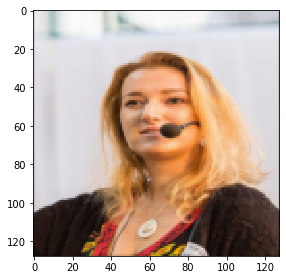

In [19]:
imshow(X_TEST[28])

**Test image original mask**

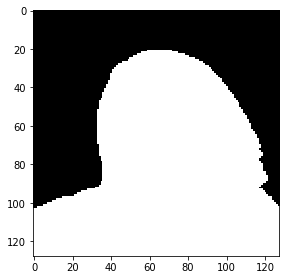

In [20]:
 imshow(np.squeeze(Y_TEST[28]))

**Our predicted mask**

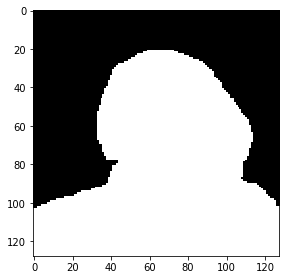

In [21]:
imshow(np.squeeze(pred[28]))

**Removing Background**

In [22]:
X_Test1 = np.copy(X_TEST)
temp = np.copy(X_TRAIN)

In [23]:
def ShowImage(value):
    for i in range(0,128):
          for j in range(0,128):
                for k in range(0,3):
                    if pred[value][i][j]==False:
                        X_Test1[value][i][j][k]=255
    imshow(X_Test1[value])

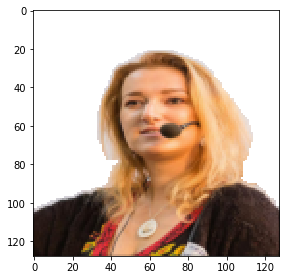

In [24]:
ShowImage(28)

In [30]:
pwd

'C:\\Users\\HP\\Desktop\\AI Project'